In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from scipy.stats import randint, uniform
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv("mergedfile_patient_age_yearsall.txt", sep="\t")

In [4]:
mutation_cols = df.columns[1:12941]     
meta_cols_before = df.columns[:1]     
meta_cols_after = df.columns[12941:]    
new_cols = pd.DataFrame(index=df.index)
for col in mutation_cols:
    parts = col.split(',')
    base = parts[0]      
    alleles = parts[1:]  
    col_numeric = pd.to_numeric(df[col], errors='coerce')
    new_cols[base] = col_numeric.apply(lambda x: 1 if x > 0 else 0)
    for i, allele in enumerate(alleles, start=1):
        allele_col = base[:-1] + allele  # e.g., A1C (remove '*')
        new_cols[allele_col] = col_numeric.apply(lambda x: 1 if x == i else 0)
final_df = pd.concat([df[meta_cols_before], new_cols, df[meta_cols_after]], axis=1)

In [5]:
cols_with_star = [col for col in final_df.columns if '*' in col]
print(cols_with_star[:10]) 

['A1*', 'T2*', 'T3*', 'A4*', 'A5*', 'A6*', 'G7*', 'G8*', 'T9*', 'T10*']


In [6]:
final_df = final_df.drop(columns=cols_with_star)

In [7]:
final_df

,strain,A1C,A1G,A1T,T2G,T2K,T2A,T2C,T3C,T3A,...,A29875G,A29876G,A29877T,A29891G,A29892G,Location,Gender,Patient age,Additional host information,Lineage
0,hCoV-19/Turkey/TSIM_Ankara_140111_978/2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Europe / Turkey,Male,87.00,Severe,B
1,hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,Europe / Slovakia / Okres Presov,Female,91.00,Severe,B.1.1.529
2,hCoV-19/Brazil/RJ-FIOCRUZ-51/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,South America / Brazil / Rio de Janeiro / Rio ...,Male,35.00,Severe,BA.1
3,hCoV-19/Fujian/FCDC-FZ9970725/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,Asia / China / Fujian,Male,70.00,Severe,EG.5.1.1
4,hCoV-19/Fujian/FCDC-XM010309HG/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,Asia / China / Fujian,Female,19.00,Severe,HK.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13972,hCoV-19/Spain/CT-LabRefCat-9317885r/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,Europe / Spain / Catalunya / Mataro,Male,94.00,Severe,JN.1.4 (consensus call)
13973,hCoV-19/Spain/CT-LabRefCat-6385185r/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,Europe / Spain / Catalunya / Mataro,Female,81.00,Severe,KP.3.1.1 (consensus call)
13974,hCoV-19/USA/NY-WMC-6178/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,North America / USA / New York / Westchester C...,Male,0.42,Severe,JN.1.4 (consensus call)
13975,hCoV-19/Mexico/GUA_CIAD_01001002/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,North America / Mexico / Guanajuato,Female,26.00,Severe,XBB.1.16.15


In [8]:
final_df.drop(columns=['Location', 'Lineage', 'Additional host information'], inplace=True)

In [9]:
metadatatwo = pd.read_csv("metadata2.txt", sep="\t")
finalfile = pd.merge(final_df, metadatatwo, on="strain")

In [10]:
finalfile

,strain,A1C,A1G,A1T,T2G,T2K,T2A,T2C,T3C,T3A,...,A29877T,A29891G,A29892G,Gender,Patient age,clade,Nextclade_pango,region,country,category
0,hCoV-19/Turkey/TSIM_Ankara_140111_978/2024,0,0,0,0,0,0,0,0,0,...,0,0,0,Male,87.00,19A,B,Europe,Turkey,Severe
1,hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,91.00,recombinant,XCU,Europe,Slovakia,Severe
2,hCoV-19/Brazil/RJ-FIOCRUZ-51/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,35.00,21K,BA.1,South America,Brazil,Severe
3,hCoV-19/Fujian/FCDC-FZ9970725/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,70.00,23F,EG.5.1.1,Asia,China,Severe
4,hCoV-19/Fujian/FCDC-XM010309HG/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,19.00,23H,HK.3,Asia,China,Severe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13972,hCoV-19/Spain/CT-LabRefCat-9317885r/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,94.00,24A,JN.1.4.9,Europe,Spain,Severe
13973,hCoV-19/Spain/CT-LabRefCat-6385185r/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,81.00,24E,KP.3.1.1,Europe,Spain,Severe
13974,hCoV-19/USA/NY-WMC-6178/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,0.42,24A,JN.1.4,North America,USA,Severe
13975,hCoV-19/Mexico/GUA_CIAD_01001002/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,26.00,23B,XBB.1.16.15,North America,Mexico,Severe


In [11]:
finalfile['Gender'] = finalfile['Gender'].replace('Hombre', 'Male') 
finalfile['Gender'] = finalfile['Gender'].replace('Mujer', 'Female')
finalfile['Gender'] = finalfile['Gender'].replace('Malex', 'Female')
finalfile['Gender'] = finalfile['Gender'].replace('Famale', 'Female')

In [12]:
finalfile['Gender'].value_counts()

Gender
Female    7856
Male      6121
Name: count, dtype: int64

In [13]:
final_df=finalfile

In [14]:
final_df

,strain,A1C,A1G,A1T,T2G,T2K,T2A,T2C,T3C,T3A,...,A29877T,A29891G,A29892G,Gender,Patient age,clade,Nextclade_pango,region,country,category
0,hCoV-19/Turkey/TSIM_Ankara_140111_978/2024,0,0,0,0,0,0,0,0,0,...,0,0,0,Male,87.00,19A,B,Europe,Turkey,Severe
1,hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,91.00,recombinant,XCU,Europe,Slovakia,Severe
2,hCoV-19/Brazil/RJ-FIOCRUZ-51/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,35.00,21K,BA.1,South America,Brazil,Severe
3,hCoV-19/Fujian/FCDC-FZ9970725/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,70.00,23F,EG.5.1.1,Asia,China,Severe
4,hCoV-19/Fujian/FCDC-XM010309HG/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,19.00,23H,HK.3,Asia,China,Severe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13972,hCoV-19/Spain/CT-LabRefCat-9317885r/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,94.00,24A,JN.1.4.9,Europe,Spain,Severe
13973,hCoV-19/Spain/CT-LabRefCat-6385185r/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,81.00,24E,KP.3.1.1,Europe,Spain,Severe
13974,hCoV-19/USA/NY-WMC-6178/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Male,0.42,24A,JN.1.4,North America,USA,Severe
13975,hCoV-19/Mexico/GUA_CIAD_01001002/2024,0,0,0,1,0,0,0,1,0,...,1,1,1,Female,26.00,23B,XBB.1.16.15,North America,Mexico,Severe


In [15]:
final_df['category'] = pd.get_dummies(final_df['category'])['Severe'].astype(int)
print(final_df['category'].head())

0    1
1    1
2    1
3    1
4    1
Name: category, dtype: int64


In [16]:
final_df['Gender'] = pd.get_dummies(final_df['Gender'])['Female'].astype(int)
print(final_df['Gender'].head())

0    0
1    1
2    0
3    0
4    1
Name: Gender, dtype: int64


In [17]:
clade_dummies = pd.get_dummies(final_df ['clade'], prefix='clade').astype(int)
final_df  = pd.concat([final_df , clade_dummies], axis=1)
final_df  = final_df .drop(['clade', 'clade_24C'], axis = 1)

In [18]:
Nextclade_dummies = pd.get_dummies(final_df ['Nextclade_pango'], prefix='Nextclade_pango').astype(int)
final_df  = pd.concat([final_df , Nextclade_dummies], axis=1)
final_df = final_df.drop(['Nextclade_pango', 'Nextclade_pango_XEN'], axis = 1)

In [20]:
first_col = final_df.loc[:, ["strain","country"]]
first_col

,strain,country
0,hCoV-19/Turkey/TSIM_Ankara_140111_978/2024,Turkey
1,hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024,Slovakia
2,hCoV-19/Brazil/RJ-FIOCRUZ-51/2024,Brazil
3,hCoV-19/Fujian/FCDC-FZ9970725/2024,China
4,hCoV-19/Fujian/FCDC-XM010309HG/2024,China
...,...,...
13972,hCoV-19/Spain/CT-LabRefCat-9317885r/2024,Spain
13973,hCoV-19/Spain/CT-LabRefCat-6385185r/2024,Spain
13974,hCoV-19/USA/NY-WMC-6178/2024,USA
13975,hCoV-19/Mexico/GUA_CIAD_01001002/2024,Mexico


In [21]:
rest = final_df.drop(columns=['strain', 'country','region'])
rest

,A1C,A1G,A1T,T2G,T2K,T2A,T2C,T3C,T3A,A4T,...,Nextclade_pango_XEL.3,Nextclade_pango_XEP,Nextclade_pango_XEU,Nextclade_pango_XEV,Nextclade_pango_XEW,Nextclade_pango_XFB,Nextclade_pango_XFC,Nextclade_pango_XFG,Nextclade_pango_XFJ,Nextclade_pango_XFL
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13972,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
13973,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
13974,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
13975,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [22]:
filtered_rest = rest.loc[:, (rest.sum(axis=0) >= 10)]
final_df_filtered = pd.concat([first_col, filtered_rest], axis=1)
print("Filtered shape:", final_df_filtered.shape)

Filtered shape: (13977, 9608)


In [23]:
final_df_filtered

,strain,country,T2G,T3C,A4T,A4C,A5G,A6R,G7T,G8T,...,Nextclade_pango_XEC.15,Nextclade_pango_XEC.18,Nextclade_pango_XEC.2,Nextclade_pango_XEC.30,Nextclade_pango_XEC.32,Nextclade_pango_XEC.4,Nextclade_pango_XEC.8,Nextclade_pango_XEC.9,Nextclade_pango_XEE,Nextclade_pango_XEK
0,hCoV-19/Turkey/TSIM_Ankara_140111_978/2024,Turkey,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024,Slovakia,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,hCoV-19/Brazil/RJ-FIOCRUZ-51/2024,Brazil,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,hCoV-19/Fujian/FCDC-FZ9970725/2024,China,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,hCoV-19/Fujian/FCDC-XM010309HG/2024,China,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13972,hCoV-19/Spain/CT-LabRefCat-9317885r/2024,Spain,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
13973,hCoV-19/Spain/CT-LabRefCat-6385185r/2024,Spain,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
13974,hCoV-19/USA/NY-WMC-6178/2024,USA,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
13975,hCoV-19/Mexico/GUA_CIAD_01001002/2024,Mexico,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [24]:
X = final_df_filtered.drop(columns=['category', 'strain','country'])

In [25]:
y = final_df_filtered['category']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: category, dtype: int64

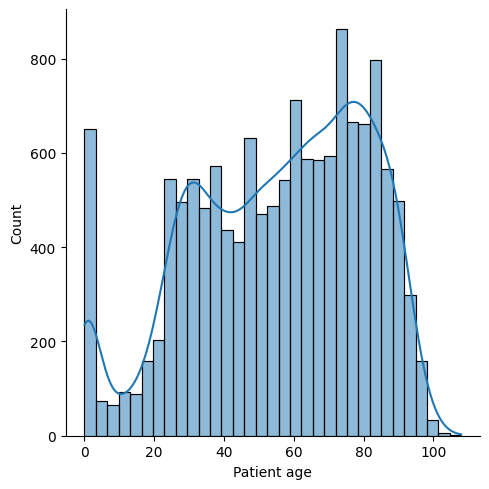

In [26]:
sns.displot(X["Patient age"], kde=True)
plt.show()

In [27]:
groups = final_df_filtered['country']


=== Fold 1: Test country = Argentina ===
Train size: 13920, Test size: 57
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8490, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.176299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13893
[LightGBM] [Info] Number of data points in the train set: 13920, number of used features: 6885
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

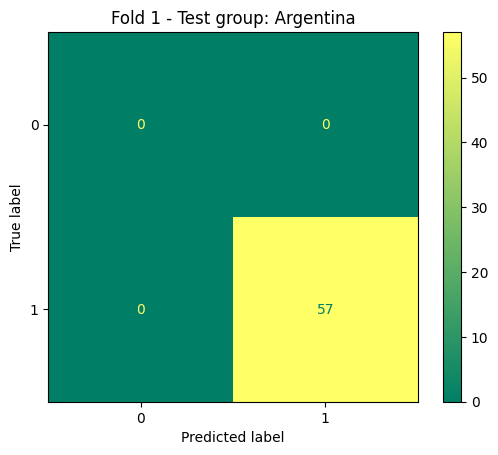


=== Fold 2: Test country = Austria ===
Train size: 13976, Test size: 1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8546, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.209188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13921
[LightGBM] [Info] Number of data points in the train set: 13976, number of used features: 6899
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.7235
Test ECE: 0.8506
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.061553662888339813), 'max_depth': 34, 'n_estimators': 2084, 'num_leaves': 36}

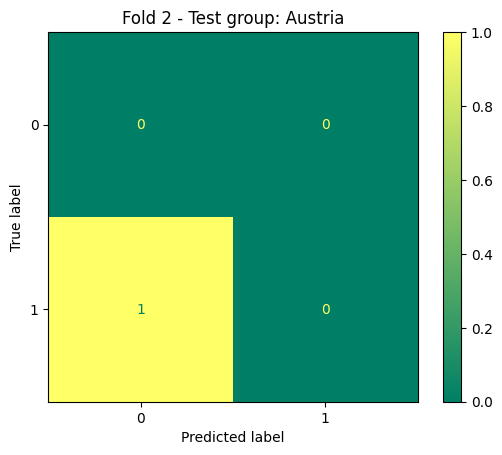


=== Fold 3: Test country = Belgium ===
Train size: 13972, Test size: 5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8542, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.216046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13921
[LightGBM] [Info] Number of data points in the train set: 13972, number of used features: 6899
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0000
Test ECE: 0.0021
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.06955116725613676), 'max_depth': 33, 'n_estimators': 1897, 'num_leaves': 41}

C

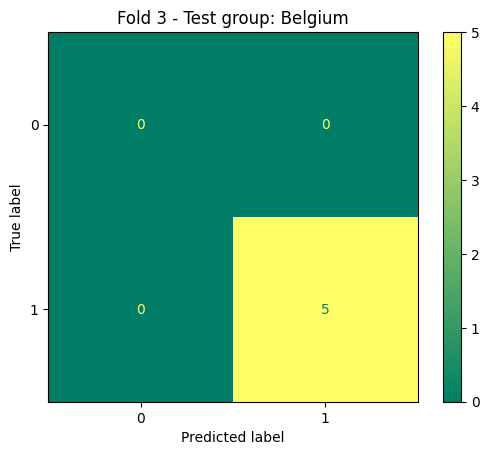


=== Fold 4: Test country = Botswana ===
Train size: 13975, Test size: 2
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8545, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13919
[LightGBM] [Info] Number of data points in the train set: 13975, number of used features: 6898
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.4143
Test ECE: 0.4551
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.061553662888339813), 'max_depth': 34, 'n_estimators': 2084, 'num_leaves': 36

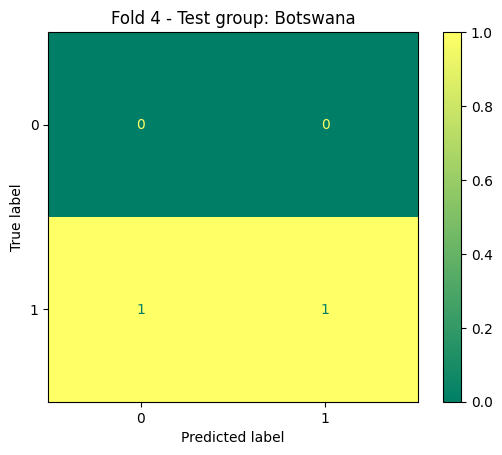


=== Fold 5: Test country = Brazil ===
Train size: 13059, Test size: 918
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7629, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.175857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12667
[LightGBM] [Info] Number of data points in the train set: 13059, number of used features: 6272
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

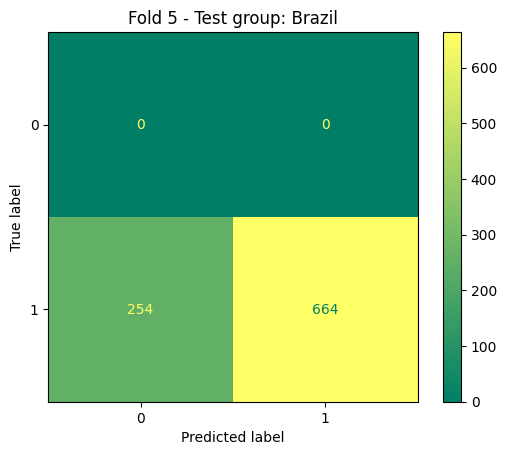


=== Fold 6: Test country = Bulgaria ===
Train size: 13976, Test size: 1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8546, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13921
[LightGBM] [Info] Number of data points in the train set: 13976, number of used features: 6899
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0000
Test ECE: 0.0000
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.06692631330513217), 'max_depth': 49, 'n_estimators': 1225, 'num_leaves': 36}

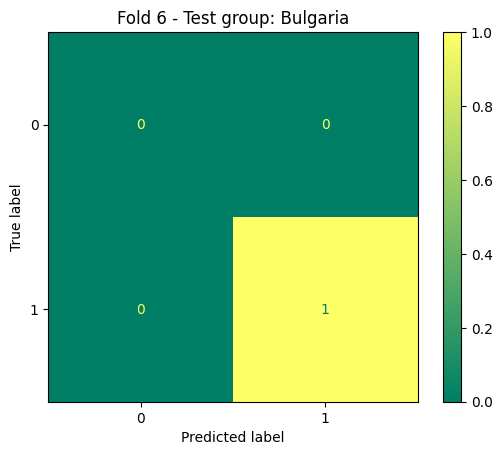


=== Fold 7: Test country = China ===
Train size: 13568, Test size: 409
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8138, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13713
[LightGBM] [Info] Number of data points in the train set: 13568, number of used features: 6795
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Te

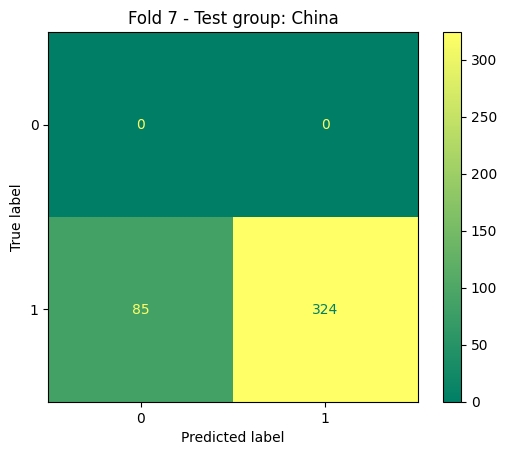


=== Fold 8: Test country = Colombia ===
Train size: 13961, Test size: 16
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8531, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.182552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13863
[LightGBM] [Info] Number of data points in the train set: 13961, number of used features: 6870
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0180
Test ECE: 0.1085
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.

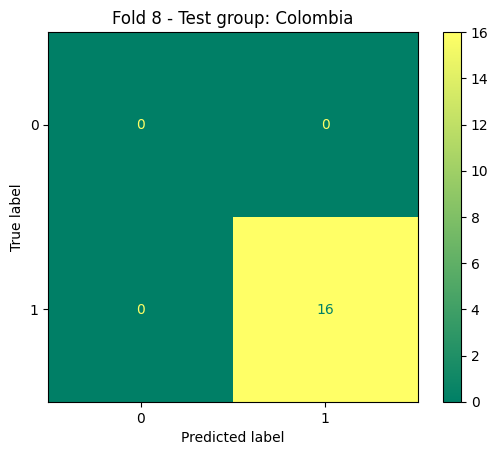


=== Fold 9: Test country = France ===
Train size: 9158, Test size: 4819
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7109, number of negative: 2049
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12812
[LightGBM] [Info] Number of data points in the train set: 9158, number of used features: 6346
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Test ROC AUC (positive class = 1): 0.5449
Test AUPRC: 0.3487
Test Brier Score: 0.4622
Test ECE: 0.4598
Test Precision (macro): 0.5387
Test Recall (macro): 0.5301
Test F1-score (macro): 0.4011

Best Parameters: {'learning_rate': np.float64(0.03627348596962052), 'max_depth': 42, 'n_estimators

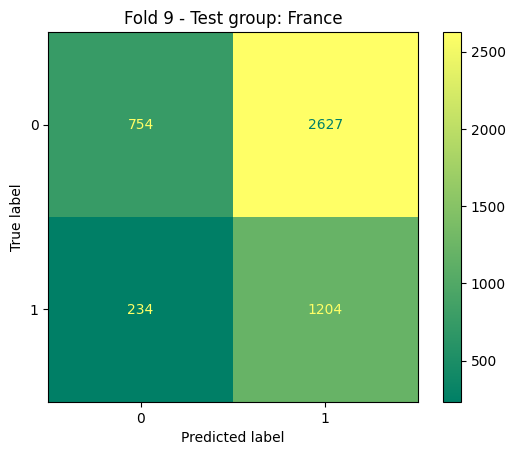


=== Fold 10: Test country = Germany ===
Train size: 13951, Test size: 26
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8521, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13893
[LightGBM] [Info] Number of data points in the train set: 13951, number of used features: 6885
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0014
Test ECE: 0.0307
Skipped Precision/Recall/F1 (only

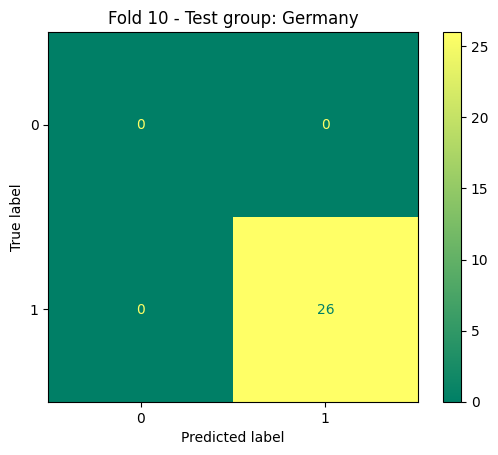


=== Fold 11: Test country = Guadeloupe ===
Train size: 13930, Test size: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8534, number of negative: 5396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.161178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13913
[LightGBM] [Info] Number of data points in the train set: 13930, number of used features: 6895
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

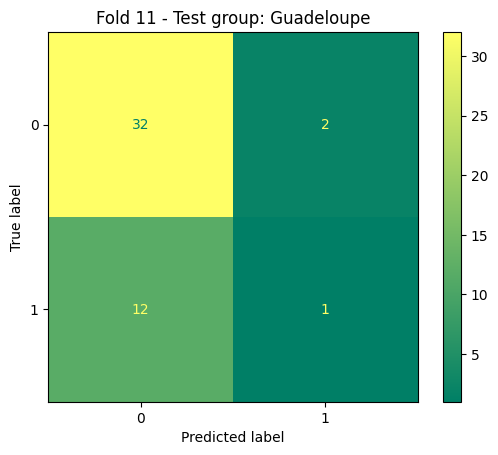


=== Fold 12: Test country = Guatemala ===
Train size: 13975, Test size: 2
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8545, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.203888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13915
[LightGBM] [Info] Number of data points in the train set: 13975, number of used features: 6896
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

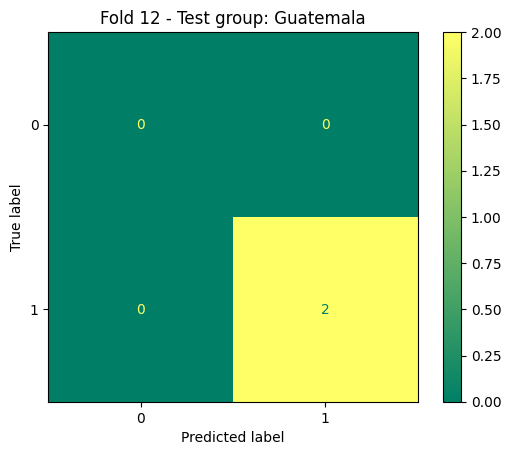


=== Fold 13: Test country = Guinea ===
Train size: 13976, Test size: 1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8546, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.152107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13921
[LightGBM] [Info] Number of data points in the train set: 13976, number of used features: 6899
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

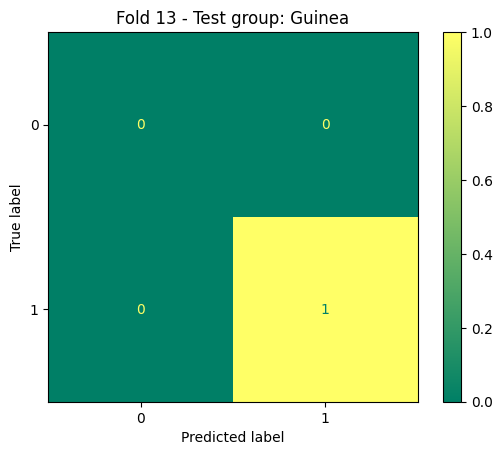


=== Fold 14: Test country = India ===
Train size: 13974, Test size: 3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8544, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.131647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13907
[LightGBM] [Info] Number of data points in the train set: 13974, number of used features: 6892
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0005
Test ECE: 0.0189
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.017881888245041864), 'max_depth': 48, 'n_estimators': 1797, 'num_leaves': 13}

C

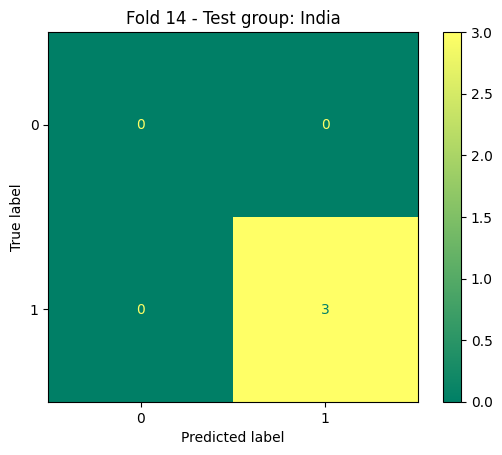


=== Fold 15: Test country = Indonesia ===
Train size: 13944, Test size: 33
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8543, number of negative: 5401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.187759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13857
[LightGBM] [Info] Number of data points in the train set: 13944, number of used features: 6867
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Test ROC AUC (positive class = 1): 0.9914
Test AUPRC: 0.9500
Test Brier Score: 0.7289
Test ECE: 0.7990
Test Precision (macro): 0.0606
Test Recall (macro): 0.5000
Test F1-score (macro): 0.1081

Best Parameters: {'learning_rate': np.float64(0.05076522329965729), 'max_depth': 32, 'n_esti

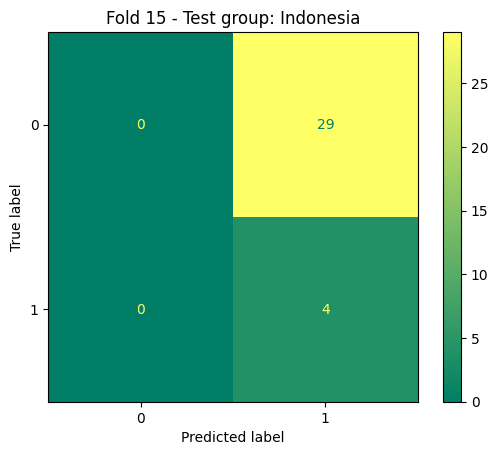


=== Fold 16: Test country = Iran ===
Train size: 13974, Test size: 3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8544, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.194066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13917
[LightGBM] [Info] Number of data points in the train set: 13974, number of used features: 6897
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0000
Test ECE: 0.0010
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.07773814951275035), 'max_depth': 43, 'n_estimators': 701, 'num_leaves': 45}

Clas

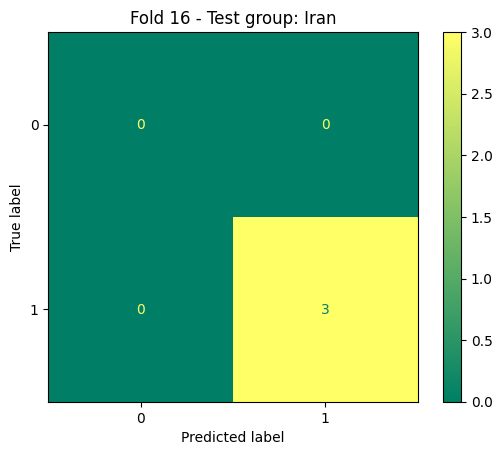


=== Fold 17: Test country = Ireland ===
Train size: 13976, Test size: 1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8546, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.196950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13921
[LightGBM] [Info] Number of data points in the train set: 13976, number of used features: 6899
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0000
Test ECE: 0.0006
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.03627348596962052), 'max_depth': 42, 'n_estimators': 1908, 'num_leaves': 36}

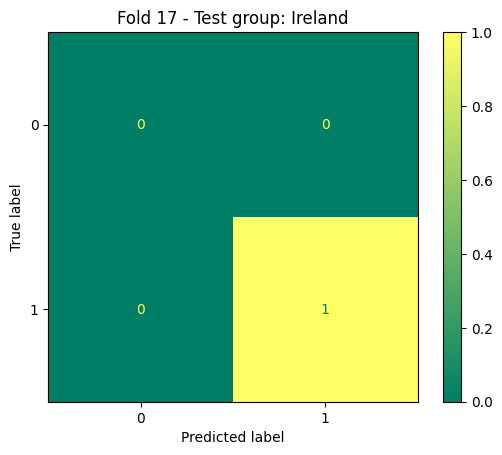


=== Fold 18: Test country = Italy ===
Train size: 13931, Test size: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8506, number of negative: 5425
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.187038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13845
[LightGBM] [Info] Number of data points in the train set: 13931, number of used features: 6861
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Test ROC AUC (positive class = 1): 0.6122
Test AUPRC: 0.9400
Test 

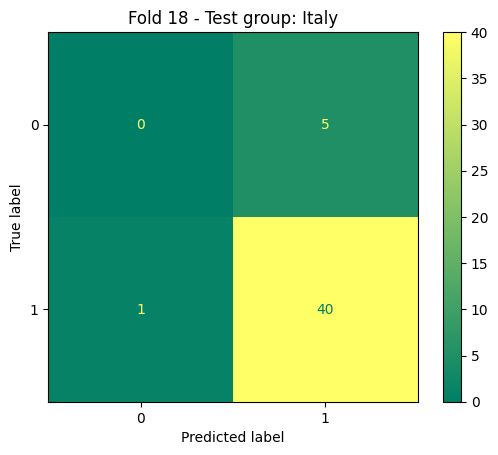


=== Fold 19: Test country = Kenya ===
Train size: 13973, Test size: 4
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8543, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.198762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13915
[LightGBM] [Info] Number of data points in the train set: 13973, number of used features: 6896
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0001
Test ECE: 0.0078
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.002580658969801205), 'max_depth': 11, 'n_estimators': 1863, 'num_leaves': 37}


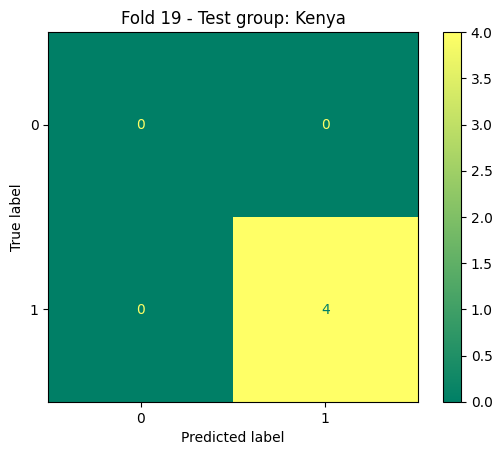


=== Fold 20: Test country = Kosovo ===
Train size: 13953, Test size: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8523, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.206185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13851
[LightGBM] [Info] Number of data points in the train set: 13953, number of used features: 6864
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
T

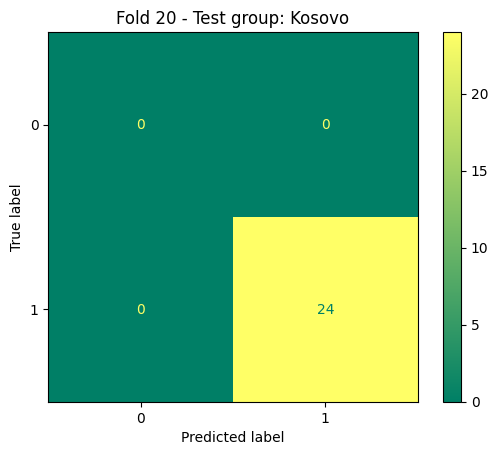


=== Fold 21: Test country = Lebanon ===
Train size: 13965, Test size: 12
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8535, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.183476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13877
[LightGBM] [Info] Number of data points in the train set: 13965, number of used features: 6877
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0009
Test ECE: 0.0218
Skipped Precision/Recall/F1 (only

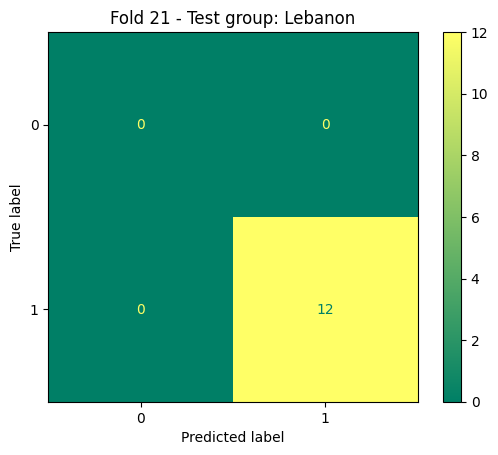


=== Fold 22: Test country = Malaysia ===
Train size: 13965, Test size: 12
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8535, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.218434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13917
[LightGBM] [Info] Number of data points in the train set: 13965, number of used features: 6897
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.2098
Test ECE: 0.3161
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.002580658969801205), 'max_depth': 11, 'n_estimators': 1863, 'num_leaves': 37

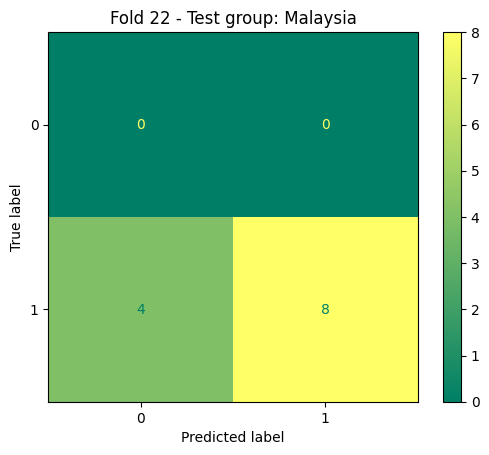


=== Fold 23: Test country = Mexico ===
Train size: 10998, Test size: 2979
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6625, number of negative: 4373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12165
[LightGBM] [Info] Number of data points in the train set: 10998, number of used features: 6021
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Test ROC AUC (positive class = 1): 0.6909
Test AUPRC: 0.7898
Test Brier Score: 0.2752
Test ECE: 0.2365
Test Precision (macro): 0.6370
Test Recall (macro): 0.6050
Test F1-score (macro): 0.6066

Best Parameters: {'learning_rate': np.float64(0.06099003750332013), 'max_depth': 48, 'n_estimat

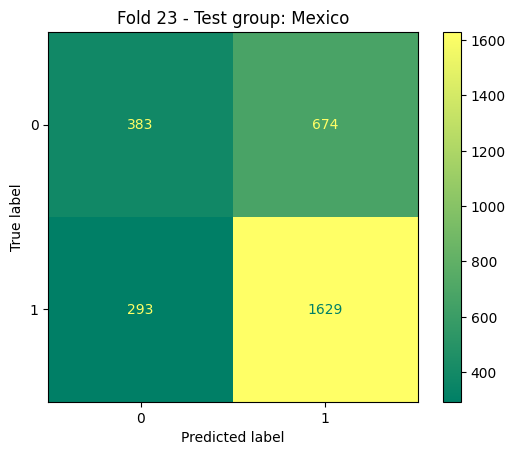


=== Fold 24: Test country = Moldova ===
Train size: 13920, Test size: 57
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8490, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.189335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13841
[LightGBM] [Info] Number of data points in the train set: 13920, number of used features: 6859
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

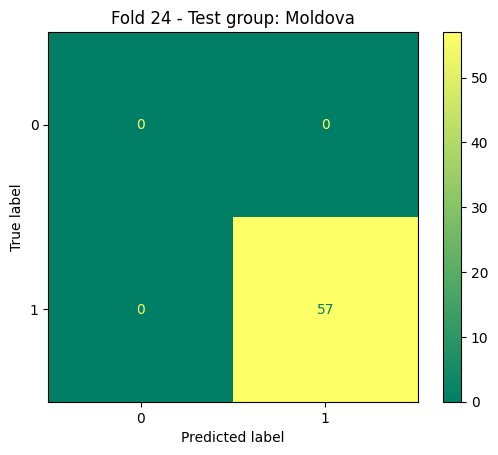


=== Fold 25: Test country = Montenegro ===
Train size: 13958, Test size: 19
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8528, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.185938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13905
[LightGBM] [Info] Number of data points in the train set: 13958, number of used features: 6891
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0005
Test ECE: 0.0166
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.002580658969801205), 'max_depth': 11, 'n_estimators': 1863, 'num_leaves'

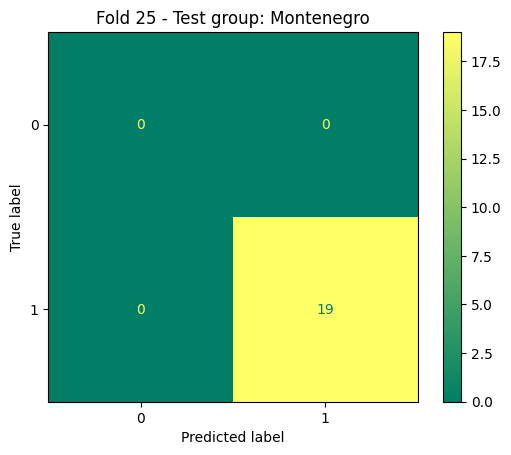


=== Fold 26: Test country = Pakistan ===
Train size: 13895, Test size: 82
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8465, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.128008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13865
[LightGBM] [Info] Number of data points in the train set: 13895, number of used features: 6871
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0239
Test ECE: 0.1319
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.002580658969801205), 'max_depth': 11, 'n_estimators': 1863, 'num_leaves': 

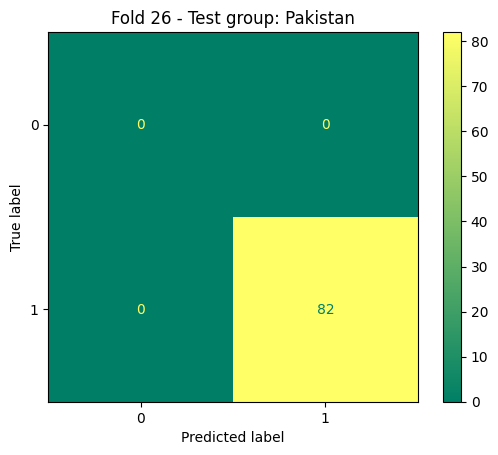


=== Fold 27: Test country = Paraguay ===
Train size: 13955, Test size: 22
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8525, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.191236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13881
[LightGBM] [Info] Number of data points in the train set: 13955, number of used features: 6879
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0001
Test ECE: 0.0090
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.002580658969801205), 'max_depth': 11, 'n_estimators': 1863, 'num_leaves': 

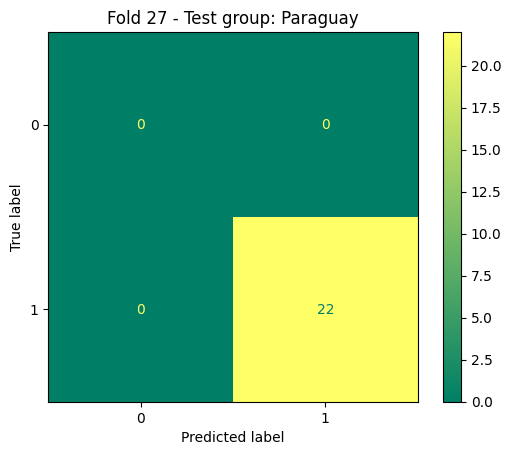


=== Fold 28: Test country = Philippines ===
Train size: 13973, Test size: 4
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8546, number of negative: 5427
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.189444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13917
[LightGBM] [Info] Number of data points in the train set: 13973, number of used features: 6897
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Test ROC AUC (positive class = 1): 1.0000
Test AUPRC: 1.0000
Test Brier Score: 0.5203
Test ECE: 0.6273
Test Precision (macro): 0.1250
Te

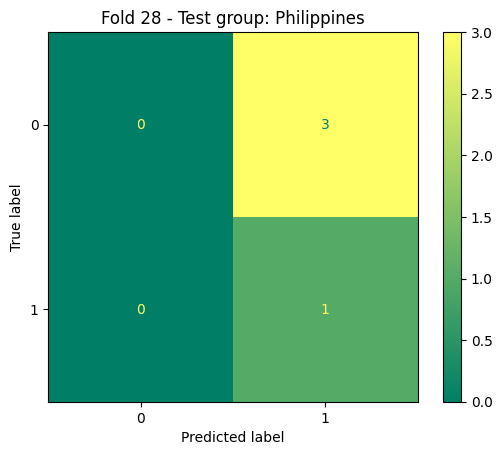


=== Fold 29: Test country = Poland ===
Train size: 13959, Test size: 18
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8529, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.210031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13893
[LightGBM] [Info] Number of data points in the train set: 13959, number of used features: 6885
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0022
Test ECE: 0.0432
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.0

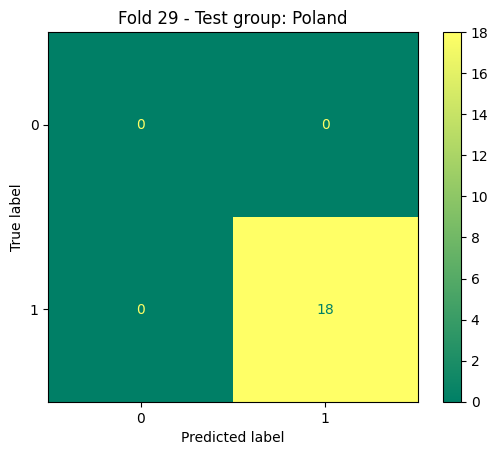


=== Fold 30: Test country = Qatar ===
Train size: 13792, Test size: 185
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8362, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.178990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13887
[LightGBM] [Info] Number of data points in the train set: 13792, number of used features: 6882
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0000
Test ECE: 0.0056
Skipped Precision/Recall/F1 (onl

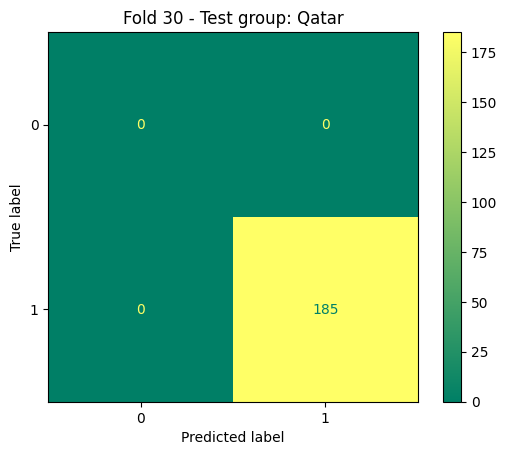


=== Fold 31: Test country = Romania ===
Train size: 13968, Test size: 9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8538, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.160057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13865
[LightGBM] [Info] Number of data points in the train set: 13968, number of used features: 6871
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0056
Test ECE: 0.0638
Skipped Precision/Recall/F1 (onl

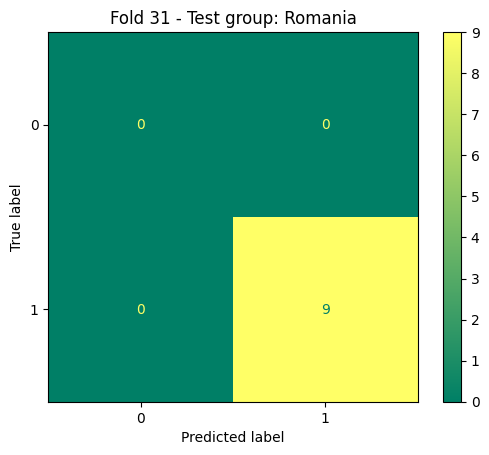


=== Fold 32: Test country = Russia ===
Train size: 13976, Test size: 1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8546, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.201232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13921
[LightGBM] [Info] Number of data points in the train set: 13976, number of used features: 6899
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0019
Test ECE: 0.0438
Skipped Precision/Recall/F1 (only

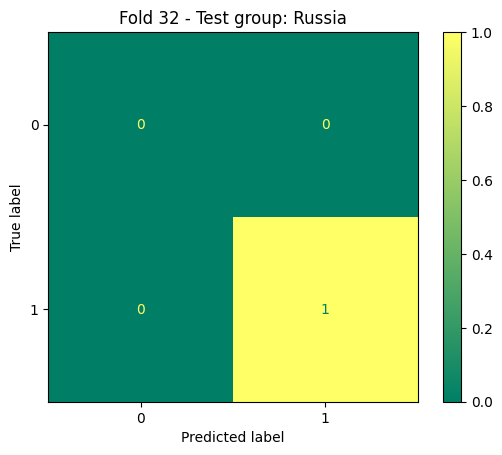


=== Fold 33: Test country = Saint Martin ===
Train size: 13976, Test size: 1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8547, number of negative: 5429
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13921
[LightGBM] [Info] Number of data points in the train set: 13976, number of used features: 6899
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
ROC AUC skipped (only one class in test set)
Test AUPRC: 0.0000
Test Brier Score: 0.0822
Test ECE: 0.2868
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.002580658969801205), 'max_depth': 11, 'n_estimators': 1863, 'num_leaves

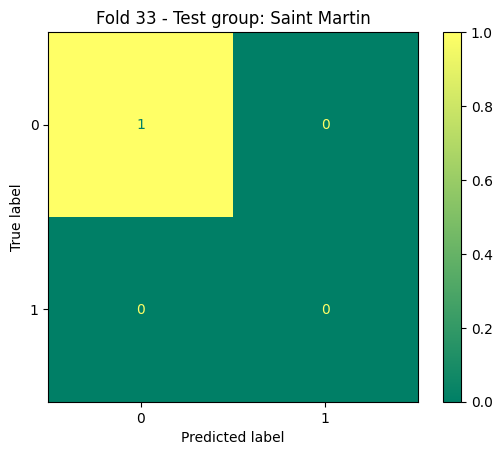


=== Fold 34: Test country = Senegal ===
Train size: 13943, Test size: 34
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8513, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.163368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13539
[LightGBM] [Info] Number of data points in the train set: 13943, number of used features: 6708
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0494
Test ECE: 0.1600
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.002580658969801205), 'max_depth': 11, 'n_estimators': 1863, 'num_leaves': 37}

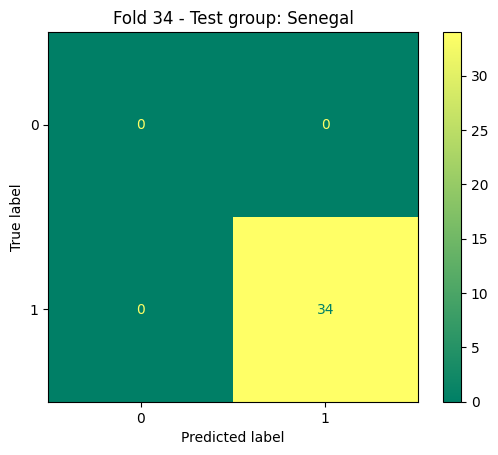


=== Fold 35: Test country = Slovakia ===
Train size: 13908, Test size: 69
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8478, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.156176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13727
[LightGBM] [Info] Number of data points in the train set: 13908, number of used features: 6802
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

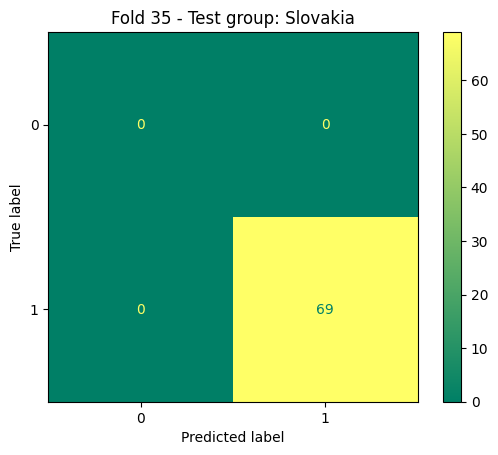


=== Fold 36: Test country = Spain ===
Train size: 10366, Test size: 3611
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5816, number of negative: 4550
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10628
[LightGBM] [Info] Number of data points in the train set: 10366, number of used features: 5254
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Test ROC AUC (positive class = 1): 0.7601
Test AUPRC: 0.9123
Test Brier Score: 0.1827
Test ECE: 0.1417
Test Precision (macro): 0.6937
Test Recall (macro): 0.5659
Test F1-score (macro): 0.5629

Best Parameters: {'learning_rate': np.float64(0.07247787845441565), 'max_depth': 39, 'n_estima

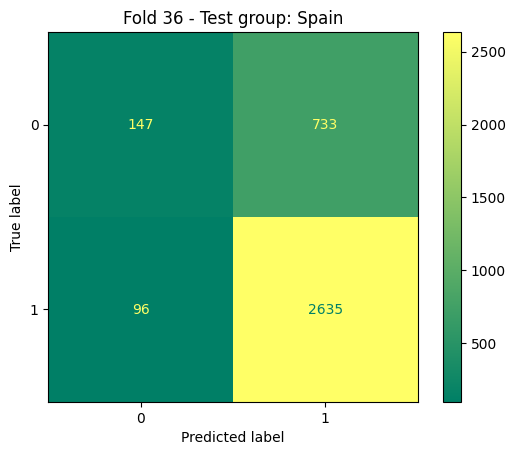


=== Fold 37: Test country = Taiwan ===
Train size: 13831, Test size: 146
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8401, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.176552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13893
[LightGBM] [Info] Number of data points in the train set: 13831, number of used features: 6885
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0241
Test ECE: 0.1325
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.002580658969801205), 'max_depth': 11, 'n_estimators': 1863, 'num_leaves': 3

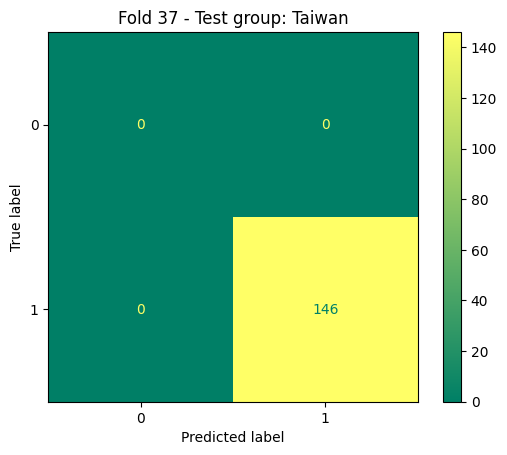


=== Fold 38: Test country = Thailand ===
Train size: 13940, Test size: 37
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8510, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.178874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13875
[LightGBM] [Info] Number of data points in the train set: 13940, number of used features: 6876
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0013
Test ECE: 0.0300
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0

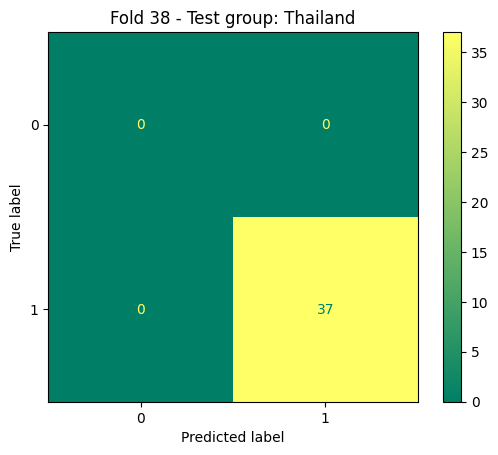


=== Fold 39: Test country = Turkey ===
Train size: 13970, Test size: 7
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8540, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.204101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13917
[LightGBM] [Info] Number of data points in the train set: 13970, number of used features: 6897
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0125
Test ECE: 0.0876
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.00

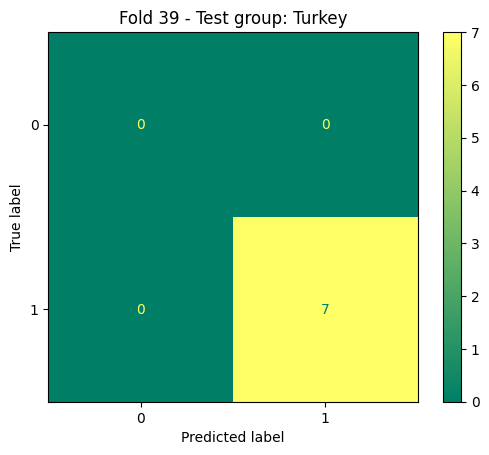


=== Fold 40: Test country = USA ===
Train size: 13745, Test size: 232
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8355, number of negative: 5390
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.130300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13682
[LightGBM] [Info] Number of data points in the train set: 13745, number of used features: 6780
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Test ROC AUC (positive class = 1): 0.5738
Test AUPRC: 0.8674
Test Brier Score: 0.1589
Test ECE: 0.1060
Test Precision (macro): 0.5667
Test Recall (macro): 0.5193
Test F1-score (macro): 0.5069

Best Parameters: {'learning_rate': np.float64(0.002580658969801205), 'max_depth': 11, 'n_estimators

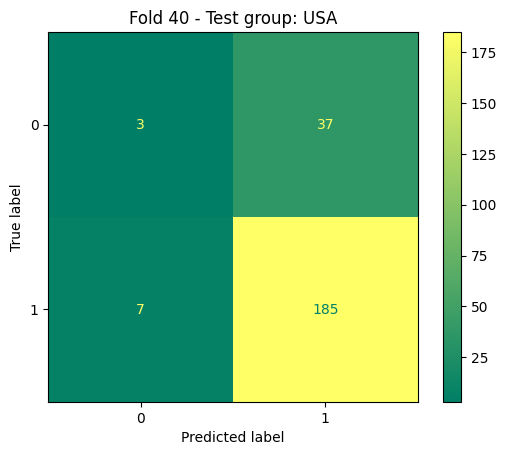


=== Fold 41: Test country = Uganda ===
Train size: 13971, Test size: 6
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8541, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.212779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13903
[LightGBM] [Info] Number of data points in the train set: 13971, number of used features: 6890
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0001
Test ECE: 0.0116
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.0025

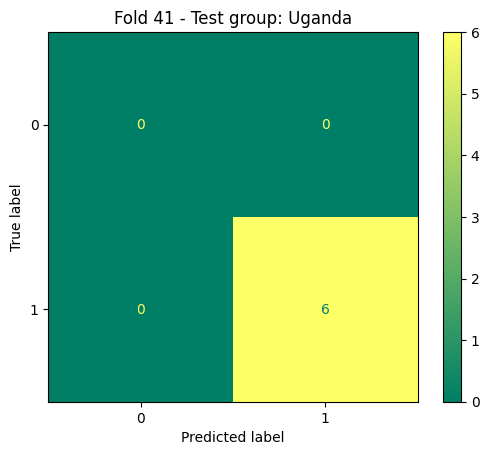


=== Fold 42: Test country = Vietnam ===
Train size: 13961, Test size: 16
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8531, number of negative: 5430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.215458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13921
[LightGBM] [Info] Number of data points in the train set: 13961, number of used features: 6899
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
ROC AUC skipped (only one class in test set)
Test AUPRC: 1.0000
Test Brier Score: 0.0084
Test ECE: 0.0879
Skipped Precision/Recall/F1 (only one class in test set)

Best Parameters: {'learning_rate': np.float64(0.002580658969801205), 'max_depth': 11, 'n_estimators': 1863, 'num_leaves': 3

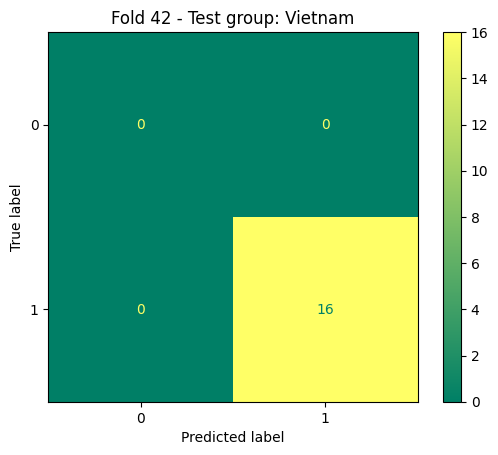


=== All Results This Run ===
    Fold       Country  Accuracy   ROC_AUC     AUPRC         Brier  \
0      1     Argentina  1.000000       NaN  1.000000  2.860545e-03   
1      2       Austria  0.000000       NaN  1.000000  7.234552e-01   
2      3       Belgium  1.000000       NaN  1.000000  1.086871e-05   
3      4      Botswana  0.500000       NaN  1.000000  4.142742e-01   
4      5        Brazil  0.723312       NaN  1.000000  1.638905e-01   
5      6      Bulgaria  1.000000       NaN  1.000000  3.092053e-16   
6      7         China  0.792176       NaN  1.000000  1.133483e-01   
7      8      Colombia  1.000000       NaN  1.000000  1.801395e-02   
8      9        France  0.406308  0.544891  0.348701  4.621780e-01   
9     10       Germany  1.000000       NaN  1.000000  1.398243e-03   
10    11    Guadeloupe  0.702128  0.771493  0.507264  1.863161e-01   
11    12     Guatemala  1.000000       NaN  1.000000  4.859316e-08   
12    13        Guinea  1.000000       NaN  1.000000  1.9672

In [28]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import randint as sp_randint, uniform as sp_uniform

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut, RandomizedSearchCV
from sklearn.metrics import (
    make_scorer, balanced_accuracy_score, accuracy_score,
    roc_auc_score, average_precision_score,
    precision_recall_fscore_support,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    brier_score_loss
)
from lightgbm import LGBMClassifier

def expected_calibration_error(y_true, y_prob, n_bins=10):
    """Expected Calibration Error (ECE)."""
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    binids = np.digitize(y_prob, bins) - 1
    ece = 0.0
    for i in range(n_bins):
        bin_mask = binids == i
        if np.any(bin_mask):
            avg_conf = y_prob[bin_mask].mean()
            avg_acc = y_true[bin_mask].mean()
            ece += np.abs(avg_conf - avg_acc) * bin_mask.mean()
    return ece

results = []
prf_macro_scores = {"precision": [], "recall": [], "f1": []}
logo = LeaveOneGroupOut()

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
    fold_num = fold + 1
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    inner_groups = groups.iloc[train_idx]
    test_country = groups.iloc[test_idx].unique()[0]

    scaler = StandardScaler()
    X_train[['Patient age']] = scaler.fit_transform(X_train[['Patient age']])
    X_test[['Patient age']] = scaler.transform(X_test[['Patient age']])

    print(f"\n=== Fold {fold_num}: Test country = {test_country} ===")
    print(f"Train size: {len(train_idx)}, Test size: {len(test_idx)}")

    param_dist = {
        'n_estimators': sp_randint(500, 2100),
        'max_depth': sp_randint(10, 51),
        'learning_rate': sp_uniform(0.001, 0.099),
        'num_leaves': sp_randint(10, 51)
    }

    try:
        from sklearn.model_selection import StratifiedGroupKFold
        inner_cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
    except Exception:
        from sklearn.model_selection import GroupKFold
        inner_cv = GroupKFold(n_splits=5)

    scorer = make_scorer(balanced_accuracy_score)

    model = LGBMClassifier(
        random_state=42,
        n_jobs=2,
        class_weight='balanced'
    )

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=50,
        scoring=scorer,
        cv=inner_cv,
        verbose=0,
        n_jobs=2,
        random_state=42
    )

    random_search.fit(X_train, y_train, groups=inner_groups)
    best_model = random_search.best_estimator_

    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    classes = best_model.classes_
    pos_class = classes[1] if len(classes) > 1 else classes[0]
    pos_idx = np.where(classes == pos_class)[0][0]
    y_prob = best_model.predict_proba(X_test)[:, pos_idx]
    y_true_bin = (y_test == pos_class).astype(int)

    roc_auc, auprc, brier, ece = np.nan, np.nan, np.nan, np.nan

    if len(np.unique(y_true_bin)) == 2:
        roc_auc = roc_auc_score(y_true_bin, y_prob)
        print(f"Test ROC AUC (positive class = {pos_class}): {roc_auc:.4f}")
    else:
        print("ROC AUC skipped (only one class in test set)")

    auprc = average_precision_score(y_true_bin, y_prob)
    brier = brier_score_loss(y_true_bin, y_prob)
    ece = expected_calibration_error(y_true_bin.values, y_prob, n_bins=10)

    print(f"Test AUPRC: {auprc:.4f}")
    print(f"Test Brier Score: {brier:.4f}")
    print(f"Test ECE: {ece:.4f}")

    if len(y_test.unique()) > 1:
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred, average='macro', zero_division=0
        )
        prf_macro_scores["precision"].append(precision)
        prf_macro_scores["recall"].append(recall)
        prf_macro_scores["f1"].append(f1)
        print(f"Test Precision (macro): {precision:.4f}")
        print(f"Test Recall (macro): {recall:.4f}")
        print(f"Test F1-score (macro): {f1:.4f}")
    else:
        print("Skipped Precision/Recall/F1 (only one class in test set)")

    print("\nBest Parameters:", random_search.best_params_)
    report = classification_report(y_test, y_pred, zero_division=0)
    print("\nClassification Report:\n", report)
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    cm_str = np.array2string(cm)
    report_str = report

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='summer', values_format='d')
    plt.title(f"Fold {fold_num} - Test group: {test_country}")
    plt.show()

    result_entry = {
        "Fold": fold_num,
        "Country": test_country,
        "Accuracy": acc,
        "ROC_AUC": roc_auc,
        "AUPRC": auprc,
        "Brier": brier,
        "ECE": ece,
        "Best_Params": random_search.best_params_,
        "Confusion_Matrix": cm_str,
        "Classification_Report": report_str
    }
    results.append(result_entry)

    with open("results.txt", "a") as f:
        f.write(f"\n=== Fold {fold_num} (Country: {test_country}) ===\n")
        for key, val in result_entry.items():
            f.write(f"{key}: {val}\n")
        f.write("\n")

results_df = pd.DataFrame(results)
print("\n=== All Results This Run ===")
print(results_df)

with open("results.txt", "a") as f:
    f.write("\n=== Summary (This Run) ===\n")
    f.write(results_df.to_string(index=False))
    f.write("\n")
    f.write(f"\nMean Accuracy: {results_df['Accuracy'].mean():.4f}\n")
    if results_df["ROC_AUC"].notna().any():
        f.write(f"Mean ROC AUC: {results_df['ROC_AUC'].dropna().mean():.4f}\n")
    if results_df["AUPRC"].notna().any():
        f.write(f"Mean AUPRC: {results_df['AUPRC'].dropna().mean():.4f}\n")
    if results_df["Brier"].notna().any():
        f.write(f"Mean Brier Score: {results_df['Brier'].dropna().mean():.4f}\n")
    if results_df["ECE"].notna().any():
        f.write(f"Mean ECE: {results_df['ECE'].dropna().mean():.4f}\n")
